## 本 ipynb 所需引入的套件

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image
import platform
import os
from tqdm import tqdm

## 環境變數設定

In [3]:
IMAGE_PATH = "Data/image1.png"  # 輸入影像路徑
GT_PATH = "Data/image1_groundtruth.png"  # 標準答案路徑
OUTPUT_PATH = "teacher/result1.png"  # 預測結果路徑
SAVE_PATH = "teacher/comparison1.png" # 比較圖的輸出

output_dir = os.path.dirname(OUTPUT_PATH)

# 如果該路徑有包含資料夾，且資料夾不存在，就建立它
if output_dir:
    os.makedirs(output_dir, exist_ok=True)
    print(f"📁 已確認/建立資料夾: {output_dir}")

📁 已確認/建立資料夾: teacher


## 模型的設定
path 需要改為您的.pth所在位置

我測試時的預設位置
```text!
MODELS_CONFIG = [
        {"arch": "UnetPlusPlus", "encoder": "timm-efficientnet-b7", "path": "best_S2_B7_Plus.pth", "weight": 1.2},
        {"arch": "UnetPlusPlus", "encoder": "densenet161", "path": "best_The_Detail_Dense161.pth", "weight": 1.0},
        {"arch": "UnetPlusPlus", "encoder": "resnet101", "path": "best_S3_Res101.pth", "weight": 1.0},
        {"arch": "UnetPlusPlus", "encoder": "efficientnet-b5", "path": "best_S2_B5.pth", "weight": 0.8},
    ]
```

In [4]:
MODELS_CONFIG = [
        {"arch": "UnetPlusPlus", "encoder": "timm-efficientnet-b7", "path": "best_S2_B7_Plus.pth", "weight": 1.2},
        {"arch": "UnetPlusPlus", "encoder": "densenet161", "path": "best_The_Detail_Dense161.pth", "weight": 1.0},
        {"arch": "UnetPlusPlus", "encoder": "resnet101", "path": "best_S3_Res101.pth", "weight": 1.0},
        {"arch": "UnetPlusPlus", "encoder": "efficientnet-b5", "path": "best_S2_B5.pth", "weight": 0.8},
    ]

## 中文字體設定

In [5]:
# 設定中文字體
def setup_chinese_font():
    """設定 matplotlib 中文字體"""
    system = platform.system()

    if system == 'Windows':
        # Windows 系統使用微軟正黑體或新細明體
        plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']
    elif system == 'Darwin':  # macOS
        plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'PingFang TC']
    else:  # Linux
        plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei', 'Noto Sans CJK TC', 'Droid Sans Fallback']

    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題


# 初始化中文字體
setup_chinese_font()

## 模型載入設定、輸入圖片的預處理、指標的運算 ( Accuracy, Precision, Recall ) 以及儲存對比圖

In [6]:
class DefectDetector:
    """
    瑕疵偵測系統 - 使用多模型集成
    結合四個 UNet++ 模型進行瑕疵偵測
    """

    # 模型配置


    def __init__(self, config, input_size=(512, 512), device='cuda'):
        """
        初始化偵測器

        參數:
            device: 運算設備 ('cuda' 或 'cpu')
            input_size: 輸入影像大小 (height, width)
        """
        self.config = config
        self.input_size = input_size  # 把這個存起來，等一下 transform 要用
        self.device = device
        self.models = []
        self.weights = []

        # 呼叫載入模型
        self._load_models()

        # 記得要在這裡設定 transforms，用到 self.input_size
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.input_size), # 👈 這裡就會用到你傳進來的 (512, 512)
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def _load_model_from_config(self, config):
        """
        從配置載入單一模型
        參考穩健的載入方式
        """
        import os

        # 檢查檔案是否存在
        if not os.path.exists(config['path']):
            print(f"❌ 找不到: {config['path']}")
            return None

        # 建立架構
        try:
            if config['arch'] == "UnetPlusPlus":
                model = smp.UnetPlusPlus(
                    encoder_name=config['encoder'],
                    encoder_weights=None,
                    in_channels=3,
                    classes=1
                )
            else:
                model = smp.Unet(
                    encoder_name=config['encoder'],
                    encoder_weights=None,
                    in_channels=3,
                    classes=1
                )
        except Exception as e:
            print(f"❌ 建立模型架構失敗: {e}")
            return None

        # 載入權重 (處理 Checkpoint 結構)
        try:
            checkpoint = torch.load(config['path'], map_location=self.device, weights_only=False)

            # 智能判斷 state_dict 的位置
            if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
                state_dict = checkpoint["model_state_dict"]
            else:
                state_dict = checkpoint

            # 載入權重，允許部分不匹配 (strict=False)
            model.load_state_dict(state_dict, strict=False)

        except Exception as e:
            print(f"❌ 載入失敗 {config['path']}: {e}")
            return None

        # 移至指定設備並設為評估模式
        model.to(self.device)
        model.eval()

        return model

    def _load_models(self):
        """載入所有模型"""
        print("\n載入模型中...")

        # 👇 這裡也要記得改用 self.config
        for idx, config in enumerate(self.config):
            print(f"  [{idx + 1}/{len(self.config)}] 載入 {config['encoder']} ... ", end='')

            model = self._load_model_from_config(config)

            if model is not None:
                self.models.append(model)
                self.weights.append(config['weight'])
                print("✓")
            else:
                print("✗")

        if len(self.models) == 0:
            raise RuntimeError("沒有成功載入任何模型！請檢查 .pth 檔案路徑")

        # 👇 修正這行：把 self.MODELS_CONFIG 改成 self.config
        print(f"\n成功載入 {len(self.models)}/{len(self.config)} 個模型")

    def _preprocess_image(self, image):
        """
        預處理影像

        參數:
            image: OpenCV 格式的影像 (BGR)

        返回:
            tensor: PyTorch tensor (1, 3, H, W)
        """
        # 轉換為 RGB
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 調整大小
        image = cv2.resize(image, self.input_size)

        # 轉換為 PIL Image
        image = Image.fromarray(image)

        # 標準化處理
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        tensor = transform(image)
        tensor = tensor.unsqueeze(0)  # 添加 batch 維度

        return tensor

    def read_image(self, image_path):
        """讀取影像"""
        img = cv2.imread(str(image_path))
        if img is None:
            raise FileNotFoundError(f"無法讀取影像: {image_path}")
        return img

    def read_ground_truth(self, gt_path):
        """
        讀取標準答案 (Ground Truth)
        老師的格式：白底黑字 (白色=正常, 黑色=瑕疵)
        """
        gt = cv2.imread(str(gt_path), cv2.IMREAD_GRAYSCALE)
        if gt is None:
            raise FileNotFoundError(f"無法讀取標準答案: {gt_path}")

        # 白底黑字格式：黑色(0)=瑕疵(1), 白色(255)=正常(0)
        # 所以要反轉：將黑色轉成1，白色轉成0
        _, gt_binary = cv2.threshold(gt, 127, 1, cv2.THRESH_BINARY_INV)

        return gt_binary

    def detect_defects(self, image):
        """
        瑕疵偵測主要演算法 - 使用模型集成

        參數:
            image: 輸入影像 (OpenCV 格式)

        返回:
            二值化的偵測結果 (0和1)
        """
        original_size = (image.shape[1], image.shape[0])  # (width, height)

        # 預處理影像
        input_tensor = self._preprocess_image(image)
        input_tensor = input_tensor.to(self.device)

        # 集成所有模型的預測結果
        ensemble_pred = None
        total_weight = sum(self.weights[:len(self.models)])

        with torch.no_grad():
            for model, weight in zip(self.models, self.weights[:len(self.models)]):
                # 模型預測
                output = model(input_tensor)
                output = torch.sigmoid(output)  # 轉換為機率值

                # 加權累加
                if ensemble_pred is None:
                    ensemble_pred = output * weight
                else:
                    ensemble_pred += output * weight

        # 平均化
        ensemble_pred = ensemble_pred / total_weight

        # 轉換為 numpy array
        pred_mask = ensemble_pred.cpu().numpy()[0, 0]

        # 調整回原始大小
        pred_mask = cv2.resize(pred_mask, original_size)

        # 二值化 (閾值設為 0.5)
        pred_binary = (pred_mask > 0.5).astype(np.uint8)

        return pred_binary

    def save_result(self, result, output_path, original_image=None, save_overlay=False):
        """
        儲存瑕疵偵測結果

        參數:
            result: 二值化的偵測結果 (0和1)
            output_path: 輸出檔案路徑
            original_image: 原始影像，用於疊加顯示
            save_overlay: 是否儲存彩色疊加版本
        """
        # 預設：儲存白底黑字格式 (與 ground truth 一致)
        # 0 (正常) -> 255 (白色)
        # 1 (瑕疵) -> 0 (黑色)
        result_visual = ((1 - result) * 255).astype(np.uint8)

        # 儲存主要結果 (白底黑字)
        cv2.imwrite(str(output_path), result_visual)
        print(f"結果已儲存至: {output_path}")

        # 可選：儲存彩色疊加版本
        if save_overlay and original_image is not None:
            overlay_path = str(output_path).replace('.png', '_overlay.png')

            # 創建彩色疊加效果
            if len(original_image.shape) == 2:
                original_bgr = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
            else:
                original_bgr = original_image.copy()

            # 將瑕疵區域標記為紅色
            overlay = original_bgr.copy()
            overlay[result == 1] = [0, 0, 255]  # 紅色 (BGR)

            # 混合原始影像和疊加層
            overlay_visual = cv2.addWeighted(original_bgr, 0.7, overlay, 0.3, 0)

            cv2.imwrite(overlay_path, overlay_visual)
            print(f"疊加版本已儲存至: {overlay_path}")

    def calculate_metrics(self, prediction, ground_truth, verbose=True):
        """
        計算評估指標

        參數:
            prediction: 預測結果 (二值化，0和1)
            ground_truth: 標準答案 (二值化，0和1)
            verbose: 是否顯示詳細除錯資訊

        返回:
            dict: 包含 Accuracy, Precision, Recall 的字典
        """
        # 確保維度一致
        if prediction.shape != ground_truth.shape:
            if verbose:
                print(f"  ⚠️  維度不一致，調整預測結果大小...")
                print(f"      預測: {prediction.shape}, 標準答案: {ground_truth.shape}")
            # 調整預測結果大小以匹配標準答案
            prediction = cv2.resize(
                prediction.astype(np.uint8),
                (ground_truth.shape[1], ground_truth.shape[0]),
                interpolation=cv2.INTER_NEAREST
            )

        # 除錯資訊：檢查數值範圍
        if verbose:
            print(f"\n  [除錯資訊]")
            print(f"  預測結果唯一值: {np.unique(prediction)}")
            print(f"  標準答案唯一值: {np.unique(ground_truth)}")
            print(
                f"  預測瑕疵像素數: {np.sum(prediction == 1)} / {prediction.size} ({np.sum(prediction == 1) / prediction.size * 100:.2f}%)")
            print(
                f"  標準瑕疵像素數: {np.sum(ground_truth == 1)} / {ground_truth.size} ({np.sum(ground_truth == 1) / ground_truth.size * 100:.2f}%)")

        # 展平為一維陣列
        pred_flat = prediction.flatten()
        gt_flat = ground_truth.flatten()

        # 計算混淆矩陣元素
        tp = np.sum((pred_flat == 1) & (gt_flat == 1))  # True Positive
        tn = np.sum((pred_flat == 0) & (gt_flat == 0))  # True Negative
        fp = np.sum((pred_flat == 1) & (gt_flat == 0))  # False Positive
        fn = np.sum((pred_flat == 0) & (gt_flat == 1))  # False Negative

        # 計算指標
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        # 四捨五入至小數點第三位
        metrics = {
            'Accuracy': round(accuracy, 3),
            'Precision': round(precision, 3),
            'Recall': round(recall, 3),
            'TP': int(tp),
            'TN': int(tn),
            'FP': int(fp),
            'FN': int(fn)
        }

        if verbose:
            print(f"\n  [混淆矩陣分析]")
            print(f"  TP (預測瑕疵且正確): {tp:,}")
            print(f"  TN (預測正常且正確): {tn:,}")
            print(f"  FP (預測瑕疵但錯誤): {fp:,}")
            print(f"  FN (漏掉的瑕疵):    {fn:,}")

            if fp > tp * 10:
                print(f"\n  ⚠️  警告: FP >> TP，可能是標註顏色相反！")
                print(f"     建議檢查: ground truth 是「黑色=瑕疵」還是「白色=瑕疵」")
            if fn > tp * 10:
                print(f"\n  ⚠️  警告: FN >> TP，模型可能沒有偵測到瑕疵")

        return metrics

    def visualize_results(self, original, ground_truth, prediction, metrics, save_path=None):
        """視覺化結果"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # 原始影像
        if len(original.shape) == 2:
            axes[0, 0].imshow(original, cmap='gray')
        else:
            axes[0, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title('原始影像', fontsize=12)
        axes[0, 0].axis('off')

        # 標準答案 (Ground Truth)
        axes[0, 1].imshow(ground_truth, cmap='gray')
        axes[0, 1].set_title(f'標準答案 (Ground Truth)\n瑕疵像素: {np.sum(ground_truth == 1):,}', fontsize=12)
        axes[0, 1].axis('off')

        # 預測結果
        axes[1, 0].imshow(prediction, cmap='gray')
        axes[1, 0].set_title(f'預測結果\n瑕疵像素: {np.sum(prediction == 1):,}', fontsize=12)
        axes[1, 0].axis('off')

        # 差異比較圖
        diff = np.zeros((*prediction.shape, 3), dtype=np.uint8)
        diff[prediction == ground_truth] = [240, 240, 240]  # 淺灰色 = 正確
        diff[(prediction == 1) & (ground_truth == 0)] = [255, 100, 100]  # 淺紅色 = FP (誤報)
        diff[(prediction == 0) & (ground_truth == 1)] = [100, 150, 255]  # 淺藍色 = FN (漏報)

        axes[1, 1].imshow(diff)
        axes[1, 1].set_title(
            f'差異比較\n'
            f'灰色：正確  紅色：誤報(FP)  藍色：漏報(FN)\n'
            f'Acc: {metrics["Accuracy"]:.3f} | '
            f'Prec: {metrics["Precision"]:.3f} | '
            f'Rec: {metrics["Recall"]:.3f}',
            fontsize=11
        )
        axes[1, 1].axis('off')

        plt.tight_layout()

        if SAVE_PATH:
            plt.savefig(SAVE_PATH, dpi=150, bbox_inches='tight')
            print(f"視覺化結果已儲存至: {SAVE_PATH}")

        plt.show()

## main()函式的設定

In [7]:
def main():
    """主程式流程"""
    import os

    # 1. 自動判斷設備 (修正：確保 Machine B 不會崩潰)
    MY_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"🖥️  目前使用的設備: {MY_DEVICE}")

    # 2. 自動建立輸出資料夾 (修正：加入自動建資料夾功能)
    for path in [OUTPUT_PATH, SAVE_PATH]:
        folder = os.path.dirname(path)
        if folder:
            os.makedirs(folder, exist_ok=True)

    print("=" * 60)
    print("瑕疵偵測系統 - 多模型集成")
    print("=" * 60)

    # 3. 初始化偵測器
    detector = DefectDetector(
        config=MODELS_CONFIG,
        device=MY_DEVICE,      # 👈 修正：這裡改成變數，不要寫死 'cuda'
        input_size=(512, 512)
    )

    try:
        # 4. 讀取影像
        print(f"\n讀取影像: {IMAGE_PATH}")
        image = detector.read_image(IMAGE_PATH)
        print(f"  影像大小: {image.shape[1]}x{image.shape[0]}")

        # 5. 偵測瑕疵 (不管有沒有 GT，這步一定要做)
        print("\n偵測瑕疵中...")
        prediction = detector.detect_defects(image)
        print("  偵測完成！")

        # 6. 儲存結果影像
        print(f"\n儲存結果至: {OUTPUT_PATH}")
        detector.save_result(prediction, OUTPUT_PATH, image, save_overlay=True)

        # 7. 嘗試讀取 GT 並計算指標 (修正：改為軟性檢查，找不到 GT 也不會當機)
        if os.path.exists(GT_PATH):
            print(f"\n發現標準答案: {GT_PATH}")
            ground_truth = detector.read_ground_truth(GT_PATH)

            # 計算指標
            print("計算評估指標...")
            metrics = detector.calculate_metrics(prediction, ground_truth, verbose=True)

            # 顯示結果
            print("\n" + "=" * 60)
            print("評估結果")
            print("=" * 60)
            print(f"Accuracy:  {metrics['Accuracy']}")
            print(f"Precision: {metrics['Precision']}")
            print(f"Recall:    {metrics['Recall']}")
            print("=" * 60)

            # 8. 視覺化結果
            print(f"\n生成視覺化比較圖至: {SAVE_PATH}")
            detector.visualize_results(
                image,
                ground_truth,
                prediction,
                metrics,
                save_path=SAVE_PATH  # 👈 修正：補上這裡，比較圖才會存檔！
            )
            return metrics
        else:
            print(f"\n⚠️  警告: 找不到標準答案檔案 [{GT_PATH}]")
            print("   -> 已跳過評估指標計算 (Result 仍已儲存)")
            return None

    except FileNotFoundError as e:
        print(f"\n❌ 檔案錯誤: {e}")
        print("\n請確認以下檔案存在:")
        print(f"  - 輸入影像: {IMAGE_PATH}")
        print(f"  - 模型檔案: 檢查 MODELS_CONFIG 中的所有 .pth 檔案")
    except Exception as e:
        print(f"\n❌ 發生錯誤: {e}")
        import traceback
        traceback.print_exc()

## 按下去就會有結果了
### 順道一提，對比圖的 groundtruth 變成黑底白字是正常的，pytorch 是吃黑底白字的格式

🖥️  目前使用的設備: cuda
瑕疵偵測系統 - 多模型集成

載入模型中...
  [1/4] 載入 timm-efficientnet-b7 ... ✓
  [2/4] 載入 densenet161 ... ✓
  [3/4] 載入 resnet101 ... ✓
  [4/4] 載入 efficientnet-b5 ... ✓

成功載入 4/4 個模型

讀取影像: Data/image1.png
  影像大小: 512x512

偵測瑕疵中...
  偵測完成！

儲存結果至: teacher/result1.png
結果已儲存至: teacher/result1.png
疊加版本已儲存至: teacher/result1_overlay.png

發現標準答案: Data/image1_groundtruth.png
計算評估指標...

  [除錯資訊]
  預測結果唯一值: [0 1]
  標準答案唯一值: [0 1]
  預測瑕疵像素數: 9375 / 262144 (3.58%)
  標準瑕疵像素數: 9538 / 262144 (3.64%)

  [混淆矩陣分析]
  TP (預測瑕疵且正確): 8,474
  TN (預測正常且正確): 251,705
  FP (預測瑕疵但錯誤): 901
  FN (漏掉的瑕疵):    1,064

評估結果
Accuracy:  0.993
Precision: 0.904
Recall:    0.888

生成視覺化比較圖至: teacher/comparison1.png
視覺化結果已儲存至: teacher/comparison1.png


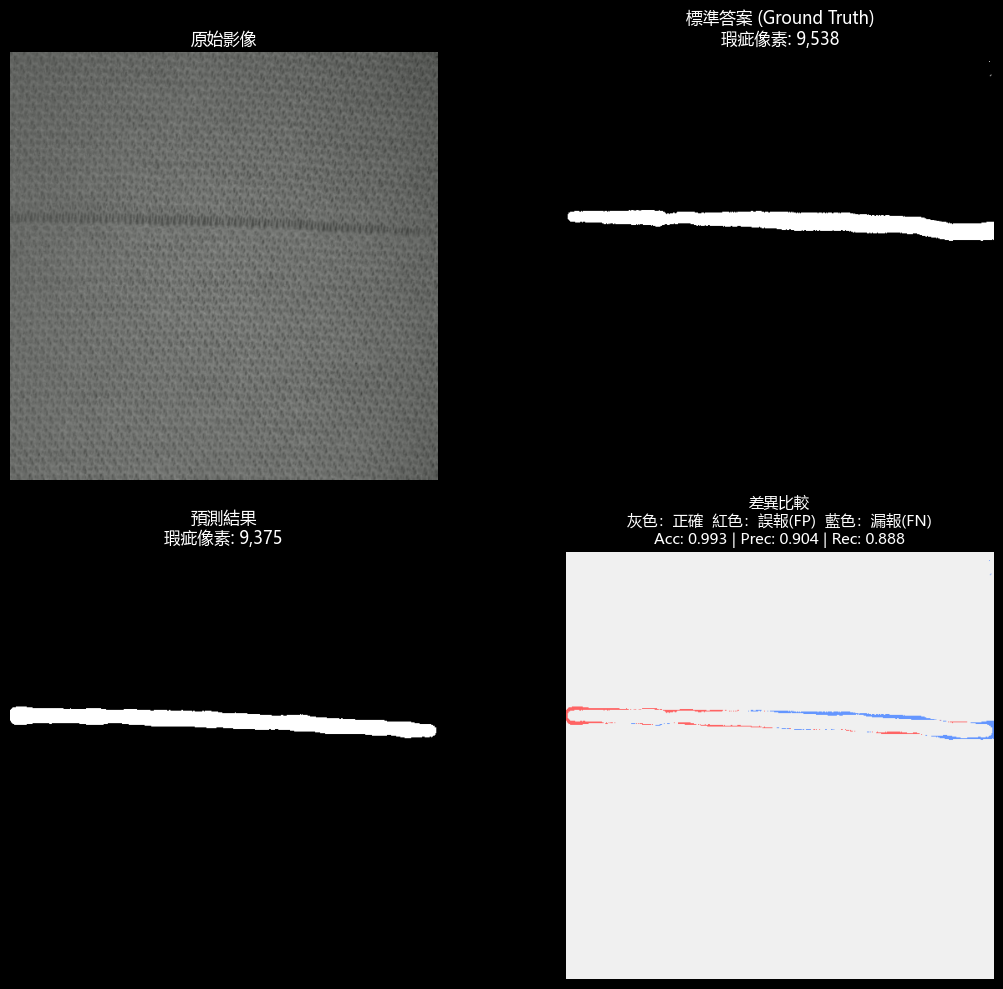

In [11]:
# 執行主程式
if __name__ == "__main__":
    main()

## 影片渲染區 ( 圈起來版 ) 跟下面的 填滿版擇一跑就好，滿快的大概三到四分鐘可以跑完
## 設定區域


In [12]:
# ==========================================
# 1. 設定區域
# ==========================================
INPUT_VIDEO_PATH = 'Data/texture_video_1.avi'  # 輸入影片
OUTPUT_VIDEO_PATH = 'output_render_5090.mp4'  # 輸出影片
DEVICE = torch.device('cuda')

MODELS_CONFIG = [
    {"arch": "UnetPlusPlus", "encoder": "timm-efficientnet-b7", "path": "best_S2_B7_Plus.pth", "weight": 1.2},
    {"arch": "UnetPlusPlus", "encoder": "densenet161", "path": "best_The_Detail_Dense161.pth", "weight": 1.0},
    {"arch": "UnetPlusPlus", "encoder": "resnet101", "path": "best_S3_Res101.pth", "weight": 1.0},
    {"arch": "UnetPlusPlus", "encoder": "efficientnet-b5", "path": "best_S2_B5.pth", "weight": 0.8},
]


IMG_HEIGHT = 512
IMG_WIDTH = 512
FINAL_THRESHOLD = 0.5

## 模型區

In [13]:
# ==========================================
# 2. 工具函式 (載入模型)
# ==========================================
def load_model_from_config(config):
    if not os.path.exists(config['path']):
        print(f"❌ 找不到: {config['path']}")
        return None

    # 建立架構
    if config['arch'] == "UnetPlusPlus":
        model = smp.UnetPlusPlus(encoder_name=config['encoder'], encoder_weights=None, classes=1)
    else:
        model = smp.Unet(encoder_name=config['encoder'], encoder_weights=None, classes=1)

    # 載入權重 (處理 Checkpoint 結構)
    try:
        checkpoint = torch.load(config['path'], map_location=DEVICE, weights_only=False)
        state_dict = checkpoint["model_state_dict"] if (
                    isinstance(checkpoint, dict) and "model_state_dict" in checkpoint) else checkpoint
        model.load_state_dict(state_dict, strict=False)
    except Exception as e:
        print(f"❌ 載入失敗 {config['path']}: {e}")
        return None

    model.to(DEVICE)
    model.eval()
    return model

## 主程式

In [14]:
# ==========================================
# 3. 渲染主程式
# ==========================================
def render_holes_video():
    # --- 1. 載入模型 ---
    loaded_models = []
    weights = []
    print("🔄 正在啟動 5090 渲染引擎...")

    for cfg in MODELS_CONFIG:
        m = load_model_from_config(cfg)
        if m:
            loaded_models.append(m)
            weights.append(cfg['weight'])

    if not loaded_models:
        print("❌ 錯誤：沒有模型載入成功。")
        return

    # 權重計算準備
    weights = torch.tensor(weights).to(DEVICE).view(-1, 1, 1, 1)
    weights = weights / weights.sum()

    # --- 2. 影片設定 ---
    cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (orig_w, orig_h))

    # --- 3. 關鍵修正：加入 Normalize ---
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        # 👇 這行救了你的準確度
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    print(f"🚀 開始渲染影片 ({orig_w}x{orig_h}) ...")
    pbar = tqdm(total=total_frames, unit="frame")

    with torch.no_grad():
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # A. 推論 (Inference)
            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            input_tensor = transform(img_rgb).unsqueeze(0).to(DEVICE)

            model_outputs = []
            for model in loaded_models:
                # 取得 Logits -> Sigmoid 轉機率
                model_outputs.append(torch.sigmoid(model(input_tensor)))

            # 集成平均
            stacked_probs = torch.cat(model_outputs, dim=0)
            avg_prob = (stacked_probs * weights).sum(dim=0)

            # 轉回 numpy mask (0~1)
            pred_mask = (avg_prob > FINAL_THRESHOLD).float().squeeze().cpu().numpy()

            # B. 後處理：放大回原尺寸
            # 使用 INTER_NEAREST 保持邊緣銳利，或 INTER_LINEAR 讓邊緣平滑
            pred_mask_resized = cv2.resize(pred_mask, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)

            # 二值化 (確保遮罩乾淨)
            mask_indices = pred_mask_resized > 0.5

            # ==========================================
            # C. 視覺化渲染 (Rendering Logic)
            # ==========================================
            if mask_indices.any():  # 如果有偵測到洞
                # 1. 創建一個純紅色的圖層 (BGR: 0, 0, 255)
                # 你可以改顏色：黃色是 [0, 255, 255], 綠色是 [0, 255, 0]
                color_layer = np.zeros_like(frame)
                color_layer[mask_indices] = [0, 0, 255]

                # 2. 創建 Alpha Mask (哪裡要透明)
                # 這邊稍微複雜一點，為了只讓「洞」的地方變色，其他地方保持原樣

                # 先複製一份原始影格
                overlay = frame.copy()

                # 只在有洞的地方，把紅色蓋上去
                overlay[mask_indices] = color_layer[mask_indices]

                # 3. 半透明混合 (AddWeighted)
                # 公式: frame * alpha + overlay * (1-alpha)
                # 0.6 是原圖權重(清晰度), 0.4 是紅色權重(顯眼度)
                cv2.addWeighted(overlay, 0.4, frame, 0.6, 0, frame)

                # (選用) 畫個邊框加強輪廓
                mask_uint8 = (mask_indices * 255).astype(np.uint8)
                contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(frame, contours, -1, (255, 255, 255), 1)  # 白色細邊框

            # 寫入
            out.write(frame)

            # 即時顯示
            scale = 0.5  # 縮小一半顯示，不然 5090 跑太快螢幕裝不下
            preview = cv2.resize(frame, (0, 0), fx=scale, fy=scale)
            cv2.imshow('RTX 5090 Rendering', preview)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            pbar.update(1)

    pbar.close()
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"✅ 渲染完成！請開啟: {OUTPUT_VIDEO_PATH}")

if __name__ == "__main__":
    render_holes_video()

🔄 正在啟動 5090 渲染引擎...
🚀 開始渲染影片 (800x600) ...


 11%|█         | 601/5437 [00:51<07:12, 11.19frame/s]

KeyboardInterrupt: 

## 影片渲染區 ( 將缺陷填滿版 )
## 設定區域

In [8]:
# ==========================================
# 1. 設定區域
# ==========================================
INPUT_VIDEO_PATH = 'Data/texture_video_1.avi'  # 輸入影片
OUTPUT_VIDEO_PATH = 'output_render_5090.mp4'  # 輸出影片
DEVICE = torch.device('cuda')

In [9]:
# 模型設定 (依照你的最佳配置)
MODELS_CONFIG = [
    {"arch": "UnetPlusPlus", "encoder": "timm-efficientnet-b7", "path": "best_S2_B7_Plus.pth", "weight": 1.2},
    {"arch": "UnetPlusPlus", "encoder": "densenet161", "path": "best_The_Detail_Dense161.pth", "weight": 1.0},
    {"arch": "UnetPlusPlus", "encoder": "resnet101", "path": "best_S3_Res101.pth", "weight": 1.0},
    {"arch": "UnetPlusPlus", "encoder": "efficientnet-b5", "path": "best_S2_B5.pth", "weight": 0.8},
]


IMG_HEIGHT = 512
IMG_WIDTH = 512
FINAL_THRESHOLD = 0.5

In [10]:
# ==========================================
# 2. 工具函式 (載入模型)
# ==========================================
def load_model_from_config(config):
    if not os.path.exists(config['path']):
        print(f"❌ 找不到: {config['path']}")
        return None

    # 建立架構
    if config['arch'] == "UnetPlusPlus":
        model = smp.UnetPlusPlus(encoder_name=config['encoder'], encoder_weights=None, classes=1)
    else:
        model = smp.Unet(encoder_name=config['encoder'], encoder_weights=None, classes=1)

    # 載入權重 (處理 Checkpoint 結構)
    try:
        checkpoint = torch.load(config['path'], map_location=DEVICE, weights_only=False)
        state_dict = checkpoint["model_state_dict"] if (
                    isinstance(checkpoint, dict) and "model_state_dict" in checkpoint) else checkpoint
        model.load_state_dict(state_dict, strict=False)
    except Exception as e:
        print(f"❌ 載入失敗 {config['path']}: {e}")
        return None

    model.to(DEVICE)
    model.eval()
    return model

In [11]:
# ==========================================
# 3. 渲染主程式
# ==========================================
def render_holes_video():
    # --- 1. 載入模型 ---
    loaded_models = []
    weights = []
    print("🔄 正在啟動 5090 渲染引擎...")

    for cfg in MODELS_CONFIG:
        m = load_model_from_config(cfg)
        if m:
            loaded_models.append(m)
            weights.append(cfg['weight'])

    if not loaded_models:
        print("❌ 錯誤：沒有模型載入成功。")
        return

    # 權重計算準備
    weights = torch.tensor(weights).to(DEVICE).view(-1, 1, 1, 1)
    weights = weights / weights.sum()

    # --- 2. 影片設定 ---
    cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (orig_w, orig_h))

    # --- 3. 關鍵修正：加入 Normalize ---
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        # 👇 這行救了你的準確度
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    print(f"🚀 開始渲染影片 ({orig_w}x{orig_h}) ...")
    pbar = tqdm(total=total_frames, unit="frame")

    with torch.no_grad():
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # A. 推論 (Inference)
            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            input_tensor = transform(img_rgb).unsqueeze(0).to(DEVICE)

            model_outputs = []
            for model in loaded_models:
                # 取得 Logits -> Sigmoid 轉機率
                model_outputs.append(torch.sigmoid(model(input_tensor)))

            # 集成平均
            stacked_probs = torch.cat(model_outputs, dim=0)
            avg_prob = (stacked_probs * weights).sum(dim=0)

            # 轉回 numpy mask (0~1)
            pred_mask = (avg_prob > FINAL_THRESHOLD).float().squeeze().cpu().numpy()

            # B. 後處理：放大回原尺寸
            # 使用 INTER_NEAREST 保持邊緣銳利，或 INTER_LINEAR 讓邊緣平滑
            pred_mask_resized = cv2.resize(pred_mask, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)

            # 二值化 (確保遮罩乾淨)
            mask_indices = pred_mask_resized > 0.5

            # ==========================================
            # C. 視覺化渲染 (Rendering Logic)
            # ==========================================
            if mask_indices.any():  # 如果有偵測到洞
                # 1. 創建一個純紅色的圖層 (BGR: 0, 0, 255)
                # 你可以改顏色：黃色是 [0, 255, 255], 綠色是 [0, 255, 0]
                color_layer = np.zeros_like(frame)
                color_layer[mask_indices] = [0, 0, 255]

                # 2. 創建 Alpha Mask (哪裡要透明)
                # 這邊稍微複雜一點，為了只讓「洞」的地方變色，其他地方保持原樣

                # 先複製一份原始影格
                overlay = frame.copy()

                # 只在有洞的地方，把紅色蓋上去
                overlay[mask_indices] = color_layer[mask_indices]

                # 3. 半透明混合 (AddWeighted)
                # 公式: frame * alpha + overlay * (1-alpha)
                # 0.6 是原圖權重(清晰度), 0.4 是紅色權重(顯眼度)
                cv2.addWeighted(overlay, 0.4, frame, 0.6, 0, frame)

                # (選用) 畫個邊框加強輪廓
                mask_uint8 = (mask_indices * 255).astype(np.uint8)
                contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(frame, contours, -1, (255, 255, 255), 1)  # 白色細邊框

            # 寫入
            out.write(frame)

            # 即時顯示
            scale = 0.5  # 縮小一半顯示，不然 5090 跑太快螢幕裝不下
            preview = cv2.resize(frame, (0, 0), fx=scale, fy=scale)
            cv2.imshow('RTX 5090 Rendering', preview)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            pbar.update(1)

    pbar.close()
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"✅ 渲染完成！請開啟: {OUTPUT_VIDEO_PATH}")


if __name__ == "__main__":
    render_holes_video()

🔄 正在啟動 5090 渲染引擎...
🚀 開始渲染影片 (800x600) ...


 20%|██        | 1106/5437 [01:38<06:52, 10.51frame/s]

KeyboardInterrupt: 